In [1]:
%load_ext autoreload
%autoreload 2

import torch
from circuits_benchmark.utils.get_cases import get_cases
import iit.model_pairs as mp
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.benchmark.benchmark_case import BenchmarkCase
import os

task_idx = '3'
out_dir = f'results/tuned_lens/{task_idx}'
os.makedirs(out_dir, exist_ok=True)

task: BenchmarkCase = get_cases(indices=[task_idx])[0]

ll_model_loader = get_ll_model_loader(task, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# turn off grads
model.eval()
model.requires_grad_(False)

hl_model = task.get_hl_model()
model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_attn_scores': HookPoint(), 'b

In [2]:
%%capture
max_len = 1000
unique_test_data = task.get_clean_data(max_samples=max_len, unique_data=True)

loader = torch.utils.data.DataLoader(unique_test_data, batch_size=256, shuffle=False, drop_last=False)

In [3]:
from interp_utils.lens.tuned_lens import do_tuned_lens
from interp_utils.lens import TunedLensConfig

tuned_lens_results, labels, train_metrics = do_tuned_lens(
    model_pair, loader, 
    TunedLensConfig(
        num_epochs=50,
        lr=1e-2,
    ),
    return_train_metrics=True
)

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


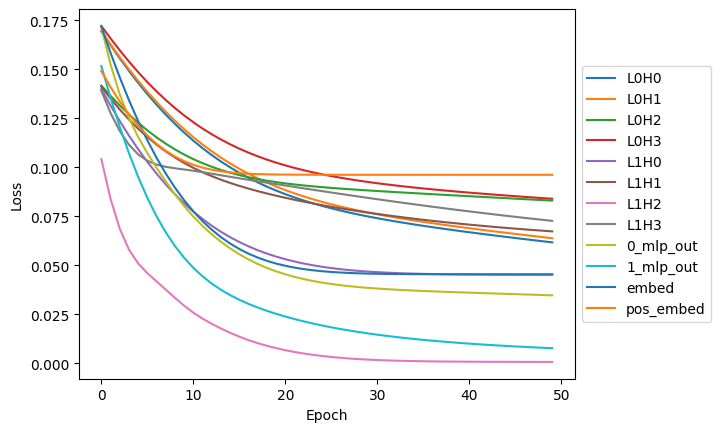

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

metric_df = pd.DataFrame(train_metrics)
metric_df.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"{out_dir}/tuned_lens_loss.pdf", bbox_inches='tight')
pass

In [5]:
from interp_utils.lens.plot_utils import get_formatted_node_names_in_circuit
nodes = get_formatted_node_names_in_circuit(model_pair=model_pair)
nodes

['0_mlp_out', 'L1H2']

Present 'nodes are not constant along the subspace of logit lens'


Plot color by is_x 

In [14]:
from interp_utils.lens.plot_utils import plot_pearson, plot_combined_pearson
# k = "L1H3"
k = "0_mlp_out"
plot_pearson(
    key=k,
    lens_results=tuned_lens_results,
    labels=labels,
    in_circuit=k in nodes,
    is_categorical=task.is_categorical(),
    tuned_lens=True,
    case_name=task.get_name(),
    show=True,
)

p-value for position 0: 0.0
p-value for position 1: 4.040345021974859e-201
p-value for position 2: 4.3461351391924664e-150
p-value for position 3: 1.0230056732019977e-102


'./interp_results//3/tuned_lens/0_mlp_out/pearson.png'

In [7]:
plot_combined_pearson(
    lens_results=tuned_lens_results,
    labels=labels,
    nodes_in_circuit=nodes,
    is_categorical=task.is_categorical(),
    tuned_lens=True,
    case_name=task.get_name(),
)

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/lens/plot_utils.py:168: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



'./interp_results//3/tuned_lens/combined_pearson.png'